DS 2500 Data and Analysis Plan  
Vivian Chen  
Gino Giorgianni  
Jordan Hardenburgh  
Kimberly Stochaj  

# Midterm Election Regression Project

The goal is to use regression techniques to compare how inflation, job growth, voter turnout, and presidential approval ratings might correlate to or influence the outcome of a midterm election, in how many senate and house seats flipped to another policial party. We hope that by the end of the project, we can know which factors have more of an effect on the outcome of a midterm, and can use the model to predict how a new midterm will fare.

# Data Processing Pipeline

Because we are getting the data from different datasets, we needed to clean each dataset individually to get the information we wanted before we could add it to one central dataframe to house all of the information. 

To easier add out data frame to the same pandas dataframe, we are going to take each of the variable csv files and clean them so we get dataframes with two columns, one for the year and one for the variable. For example, the inflation data will have a column['Year'] that includes every midterm year of avaliable data, and a column ['CPI % change May-Oct'] that houses percent change in CPI for six months before the election date of the given year. 

Once cleaned, we will perform pd.merge to combine the datasets into one, that houses the election year and all the important information.

## Where the Data comes from

We get the [Midterm Election](https://www.presidency.ucsb.edu/statistics/data/seats-congress-gainedlost-the-presidents-party-mid-term-elections) data, including presidential party, president, president approval ratings, seats to defend, and seats won or lost from the American Presidency Project. This includes information beginning with FDR in 1934. 

We get the [inflation data](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SA0;jsessionid=04BF074AA2F02CAFB14656118D04709A) from the Bureau of Labor Statistics. We will take the October data from a midterm year showing the % change in CPI over the past six month period. This will give us a good sense of how voters were perceiving and experiencing inflation leading up to the voting date. 

We get the [voter turnout](https://www.census.gov/data/tables/time-series/demo/voting-and-registration/voting-historical-time-series.html) data by dividing the sum of the population that voted in each state by the total US population. The data required came from two datasets are taken from the US Census, one that had percentage of people who voted by state by year, and one that had population by sate by year. It is important to note that the voter turnout dataset has voters both as a percentage of citizens and of total. Total was used due to corespond with the population data used - the total population of the state, not just citizens.


We get the [job growth](https://seidmaninstitute.com/job-growth/year/) data by iterating through the years to find % change of job growth within the years of the election. This data takes the Jan information from every year. This will provide some implication for how an increase or decrease in employment opportunities may impact election results. 

All these data sources are validated.


## Cleaning Inflation Data 

In [1]:
import pandas as pd

In [2]:
#Inflation Data
#import the large dataset from the inflation csv
df_inflation_big = pd.read_csv('inflation_data.csv')

#to only keep October data, identify partial strings (Months) that need to be discarded
discard = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
          'Sep', 'Nov', 'Dec']
  
# drop rows that contain the partial strings above 
#https://www.geeksforgeeks.org/how-to-drop-rows-that-contain-a-specific-string-in-pandas/
df_infl_oct = df_inflation_big[~df_inflation_big.Label.str.contains('|'.join(discard))]

#grab every fourth year (midterm years) into new df
df_infl_midterms = df_infl_oct.iloc[::4,:]

#reset the indecies to start from 0
#https://pynative.com/pandas-reset-index/
df_infl_midterms.reset_index(drop=True, inplace=True)

#make the final dataframe of only the necessary columns (year and inflaiton percent change)
df_inflation = df_infl_midterms[['Year', '6-Month % Change']].copy()

#rename the percent change column to be more easily identifiable
df_inflation.rename(columns = {'6-Month % Change': 'CPI % change may-oct'}, inplace=True)

df_inflation

,Year,CPI % change may-oct
0,1946,13.0
1,1950,4.2
2,1954,0.0
3,1958,0.0
4,1962,0.7
5,1966,1.9
6,1970,2.3
7,1974,6.5
8,1978,5.0
9,1982,3.5


## Clean voter turnout data

In [3]:
# constants for filenames
VOTE = "VoterTurnoutData.csv"
POP  = "PopulationData.csv"

def clean_voters(filename):
    """ cleans and formats the information held in the file for voter turnout
    
        Args:
            filename (str): the name of the file that data is retrieved from
                
        Returns:
            df_voters (pd.DataFrame): the cleaned and formatted voter info
    """
    # read in the csv file as the dataframe, skipping unnecessary lines
    df_voters = pd.read_csv(filename, skiprows = 3)
    
    # for our purposes, whether we use total or citizen data is unimportant, as
    # we are examining trends, so we just have to stay consistent - I chose total
    
    # set the headers to be citizen or total and drop citizen cols
    df_voters.columns = df_voters.iloc[1]
    df_voters.drop("Citizen", axis = 1, inplace = True)
   
    # change the column header to year, as this is more descriptive
    df_voters.columns = df_voters.iloc[0]
    
    # drop duplicated and empty rows
    df_voters.drop([0, 1, 2], axis = 0, inplace= True)
    
    # change the indexes to the name of the states
    df_voters.set_index("State", inplace = True)

    return df_voters


def clean_pop(filename):
    """ cleans and formats the information held in the file for population
    
        Args:
            filename (str): the name of the file that data is retrieved from
                
        Returns:
            df_voters (pd.DataFrame): the cleaned and formatted population info
    """
    # read in the csv file as the dataframe, skipping unnecessary lines
    df_pop = pd.read_csv(filename, skiprows = 4)
    
    # drop the "Fips" column
    df_pop.drop("Fips", axis = 1, inplace = True)
    
    # make the states the indexes
    df_pop.set_index("Area Name", inplace = True)
    
    return df_pop
    

def get_grand_pct(pct_lst, n_lst):
    """ converts partial percents and their population sizes and converts to 
        one overall percent
    
        Args:
            pct_lst (lst): a list of percentages
            n_lst (lst): a list of sample sizes note that index i in n_lst 
                coresponds to index i in n_lst
                
        Returns:
            grand_avg (float): description
    """
    total_voters = 0
    for i in range(len(pct_lst)):
        total_voters += pct_lst[i] * n_lst[i]
        
    total_pop = sum(n_lst)
    
    grand_avg = (total_voters / total_pop)
    return grand_avg

def get_year_data(df_vote, df_pop, year):
    """ finds the national voting percent for a given year
    
        Args:
            df_vote (pd.DataFrame): cleaned DataFrame of state voter 
                information
            df_pop (pd.DataFrame): cleaned DataFrame of state population
                information
            year (int): the year for which the average is to be calculated
        
        Returns: 
            nat_pct (float): a list of the national voting percent for 
                designated year
    """
    pct_lst = []
    pop_lst = []
    
    vote_locs = df_vote.index
    for state in vote_locs:
        if not pd.isna(df_vote.loc[state, str(year)]):
            pct_lst.append(float(df_vote.loc[state, str(year)])/100)
            pop_lst.append(int((df_pop.loc[state, str(year)]).replace(",", "")))
        
    nat_pct = get_grand_pct(pct_lst, pop_lst)
    return nat_pct
        
    
# get the cleaned DataFrames
df_pop = clean_pop(POP)
df_voters = clean_voters(VOTE)
    
    
# create the desired dataframe
voter_dict = {"Year": [], "% voter turnout": []}
    
for year in df_voters.columns:
    voter_dict["Year"].append(int(year))
    voter_dict["% voter turnout"].append(get_year_data(df_voters, df_pop, year) * 100)
        
df_voter_turnout = pd.DataFrame(voter_dict)
df_voter_turnout

,Year,% voter turnout
0,2018,50.137371
1,2014,40.754838
2,2010,44.160616
3,2006,43.506701
4,2002,42.135092
5,1998,41.884619
6,1994,45.042479
7,1990,45.022097
8,1986,45.977808
9,1982,48.519814


## Clean job growth data ###

In [4]:
# read the csv files 
df_jobs = pd.read_csv('US_jobs.csv')

# cleaned data for visualization
df_job_change = df_jobs[['Year', '% Change']]

# list of years of election
election_years = [1934, 1938, 1942, 1946, 1950, 1954, 1958, 1962, 1966, 1970, 1974, 
                  1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]

# initialize list for new data on important years
new_data = []

# filter to all the years of the election by accessing the 'year' column
df_job_growth = df_job_change.loc[df_job_change['Year'].isin(election_years)]
         
#reset the indecies to start from 0 of new dataframe
df_job_growth.reset_index(drop=True, inplace=True)

#rename the percent change column to be more easily identifiable
df_job_growth.rename(columns = {'% Change': 'Job Growth % change past year'}, inplace=True)


df_job_growth

C:\Users\KASto\AppData\Local\Temp\ipykernel_45228\1373123850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_job_growth.rename(columns = {'% Change': 'Job Growth % change past year'}, inplace=True)


,Year,Job Growth % change past year
0,1942,11.45
1,1946,-4.90
2,1950,-2.68
3,1954,-1.42
4,1958,-1.56
5,1962,2.16
6,1966,5.07
7,1970,2.53
8,1974,3.26
9,1978,4.91


## Cleaning midterm election data

In [5]:
# use pandas read_csv to read in the midterm data
df_midterm = pd.read_csv('midterm-data.csv')

# create a list of all the columns we want to drop
to_drop = ['Lame Duck?','Approval Early Aug','Approval Late Aug','Approval Early Sep',
          'Approval Late Sep']

df_midterm.drop(to_drop, inplace=True, axis=1)

df_midterm.head()

,Year,President,President's party,Approval Early Oct,Approval Late Oct,House Seats to defend,Senate Seats to defend,"Seat Change, House Seats","Seat Change, Senate Seats"
0,1934,Franklin D. Roosevelt,D,--,--,313,14,9.0,9.0
1,1938,Franklin D. Roosevelt,D,--,60,334,27,-81.0,-7.0
2,1942,Franklin D. Roosevelt,D,--,--,267,25,-46.0,-9.0
3,1946,Harry S. Truman,D,--,27,244,21,-45.0,-12.0
4,1950,Harry S. Truman,D,43,41,263,21,-29.0,-6.0


#### NOTE:
We keep the october approval ratings because we plan on using the approval ratings in our prediction and feature importance analysis

## Combining the data into one dataframe

In [6]:
#merge the inflation dataset to the midterm dataset
df_midterm = df_midterm.merge(df_inflation, on='Year', how='left')

#merge the voter turnout dataset to the midterm dataset
df_midterm = df_midterm.merge(df_voter_turnout, on='Year', how='left')

#merge the job growth dataset to the midterm dataset 
df_midterm = df_midterm.merge(df_job_growth, on='Year', how='left')

df_midterm

,Year,President,President's party,Approval Early Oct,Approval Late Oct,House Seats to defend,Senate Seats to defend,"Seat Change, House Seats","Seat Change, Senate Seats",CPI % change may-oct,% voter turnout,Job Growth % change past year
0,1934,Franklin D. Roosevelt,D,--,--,313,14,9.0,9.0,NaN,NaN,NaN
1,1938,Franklin D. Roosevelt,D,--,60,334,27,-81.0,-7.0,NaN,NaN,NaN
2,1942,Franklin D. Roosevelt,D,--,--,267,25,-46.0,-9.0,NaN,NaN,11.45
3,1946,Harry S. Truman,D,--,27,244,21,-45.0,-12.0,13.0,NaN,-4.90
4,1950,Harry S. Truman,D,43,41,263,21,-29.0,-6.0,4.2,NaN,-2.68
5,1954,Dwight D. Eisenhower,R,62,--,221,11,-18.0,-1.0,0.0,NaN,-1.42
6,1958,Dwight D. Eisenhower,R,57,--,203,20,-48.0,-13.0,0.0,NaN,-1.56
7,1962,John F. Kennedy,D,--,61,264,18,-4.0,3.0,0.7,NaN,2.16
8,1966,Lyndon B. Johnson,D,44,44,295,21,-47.0,-4.0,1.9,NaN,5.07
9,1970,Richard Nixon,R,58,--,192,7,-12.0,2.0,2.3,NaN,2.53


# Visualizations

## Visualization 1: Clustered Bar Chart Showing Midterm Results

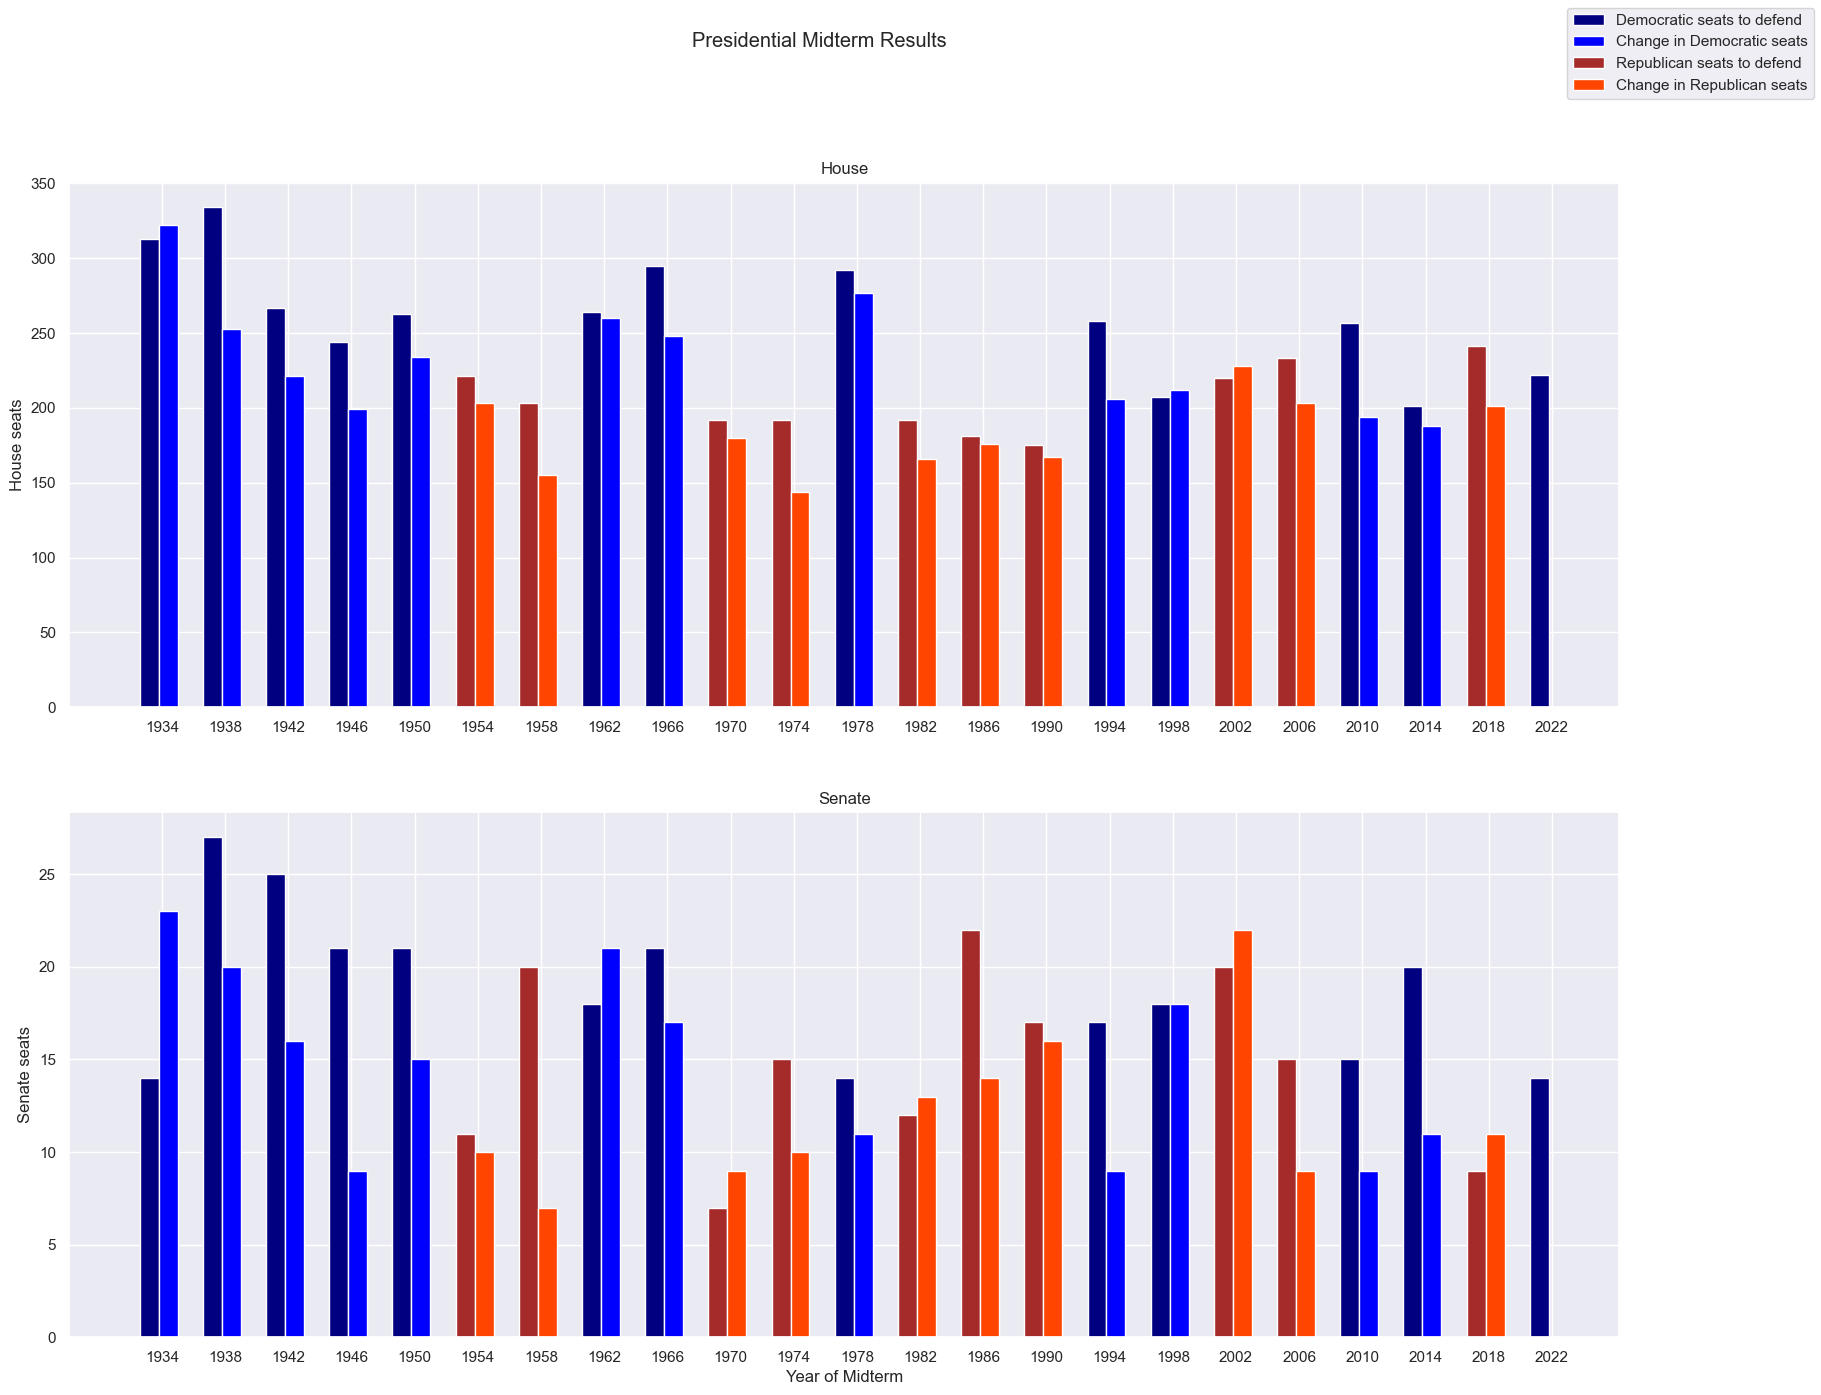

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set()

# create a subplot
fig, (ax1, ax2) = plt.subplots(2)

# to create an accurate cluster bar chart, make x the length of df_midterm
x = np.arange(len(df_midterm))
width = 0.3

plt.gcf().set_size_inches(20, 15)

# create our y values
y0 = df_midterm['House Seats to defend']
y1 = df_midterm['House Seats to defend'] + df_midterm['Seat Change, House Seats']
y2 = df_midterm['Senate Seats to defend']
y3 = df_midterm['Senate Seats to defend'] + df_midterm['Seat Change, Senate Seats']

# initialize two counters
n = 0
m = 0

# go through row and graph based on presidential party
for idx in df_midterm.index:
    
    if df_midterm["President's party"][idx] == 'R':
        n += 1 
        ax1.bar(x[idx]-0.3, y0[idx], width, color='brown', 
                label ='Republican seats to defend' if n == 1 else '')
        ax1.bar(x[idx], y1[idx], width, color='orangered', 
                label = 'Change in Republican seats' if n == 1 else '')
        ax2.bar(x[idx]-0.3, y2[idx], width, color='brown')
        ax2.bar(x[idx], y3[idx], width, color='orangered')
    
    if df_midterm["President's party"][idx] == 'D':
        m += 1
        ax1.bar(x[idx]-0.3, y0[idx], width, color='navy', 
                label ='Democratic seats to defend' if m == 1 else '')
        ax1.bar(x[idx], y1[idx], width, color='blue', 
                label = 'Change in Democratic seats' if m == 1 else '')
        ax2.bar(x[idx]-0.3, y2[idx], width, color='navy')
        ax2.bar(x[idx], y3[idx], width, color='blue')


ax1.set_xticks(x-0.1)
ax1.set_xticklabels(df_midterm['Year'])
ax2.set_xticks(x-0.1)
ax2.set_xticklabels(df_midterm['Year'])
ax1.set_title('House')
ax2.set_title('Senate')
fig.legend()

plt.suptitle('Presidential Midterm Results')
plt.xlabel("Year of Midterm")
ax1.set(ylabel = 'House seats')
ax2.set(ylabel = 'Senate seats')
plt.savefig('clean-midterm-data.png', edgecolor='black', dpi=400)
plt.show()


## Visualization 2: Line Chart of Inflation, Job Growth, and Voter Turnout in Election Years

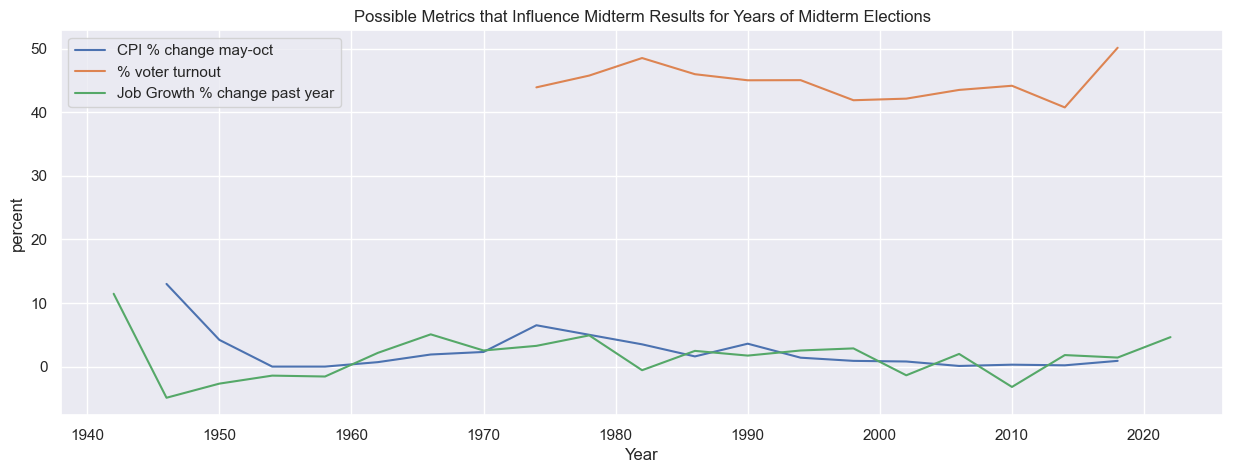

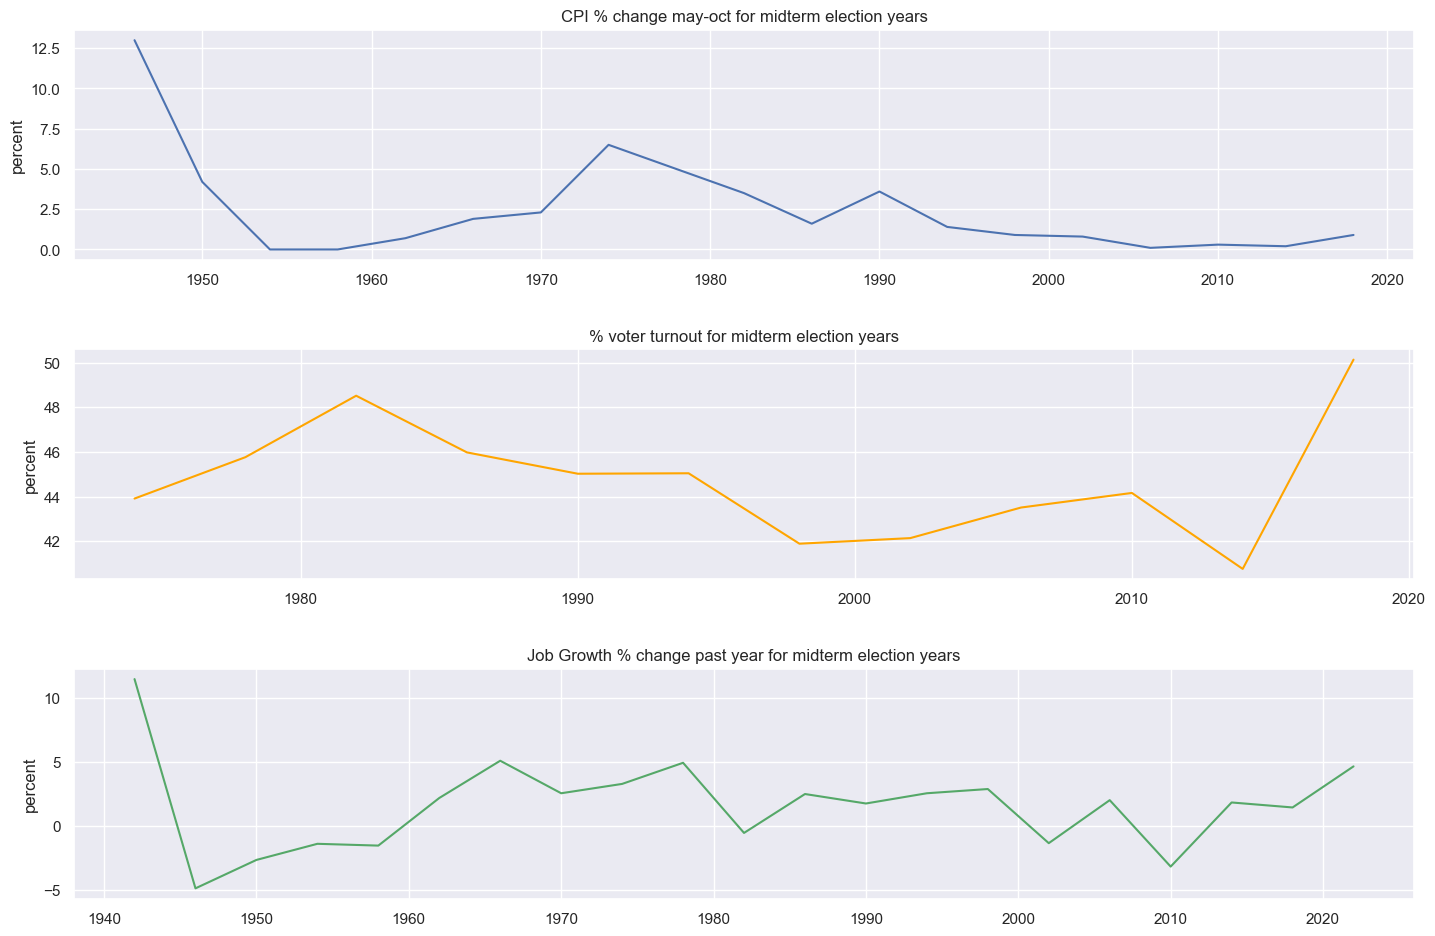

In [8]:
# plot data for all three variables together
y_lst = ["CPI % change may-oct", "% voter turnout", "Job Growth % change past year"]
df_midterm.plot(x="Year", y= y_lst)
plt.ylabel("percent")
plt.title("Possible Metrics that Influence Midterm Results for Years of Midterm Elections")
plt.gcf().set_size_inches(15, 5)
plt.show()

# create subplots for all 
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax_lst = [ax1, ax2, ax3]
color_lst = ["b", "orange", "g"]

for i in range(len(y_lst)):
    ax_lst[i].plot(df_midterm.loc[:,"Year"], df_midterm.loc[:, y_lst[i]], color = color_lst[i])
    ax_lst[i].set_title(f"{y_lst[i]} for midterm election years")
    ax_lst[i].set_ylabel("percent")

plt.gcf().set_size_inches(15, 10)
fig.tight_layout(pad =2.5)

# Data Analysis Plan 

Our hope for this project is that we are able to perform a feature importance analysis on the data we gather to see what attribute or attributes are more important for determining the outcome of a midterm election. To do this, we think using regression models on each of the categories makes the most logical sense, because we want to see a predictions made from the data. We assume that random forest regressions will work the best, but other regression methods such as linear models with single or multiple features will be attempted as well. 

We also want our model to have a predictive factor, which we think using logarithmic regression model will aid in. We will compute the MSE score, and the R2 value (using SK learn), in order to help explain the correlation between values and at how accurate our regression is at predicting outcomes. 